# Preprocessing

Hive query to pull the data:

```beeline --outputformat=csv2 -e "SELECT cvdcus_timestamp_s_3, cvdcus_dcd_sig_n_x_3, cvdcus_dcd_sig_val_str_x_3 FROM cvdp.ncvdcus_bdd_dcd_child_sec_f150_my2019_to_my2020_vw WHERE cvdcus_vin_d_3 == '1FTEW1C53KFB01079' AND cvdcus_dcd_sig_n_x_3 IN ('AirAmb_Te_ActlFilt', 'Outside_Air_Temp_Stat', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'AirCondFluidHi_P_Actl', 'CoolantFanStepAct', 'VehLong2_A_Actl', 'HvacAirCond_B_Rq', 'Veh_V_ActlEng', 'ApedPos_Pc_ActlArb', 'EngAout_N_Actl', 'HvacBlwrFront_D_Stat', 'BattULo_U_Actl', 'GPS_Latitude_Degrees', 'GPS_Longitude_Degrees', 'GearLvrPos_D_Actl', 'Ignition_Status', 'DriverWindowPosition', 'RearPassWindowPos', 'PassWindowPosition', 'BrkTot_Tq_Actl', 'OdometerMasterValue') AND cvdcus_timestamp_s_3 BETWEEN '2019-05-01' and '2019-08-30' ORDER BY cvdcus_timestamp_s_3" > /u/achopra8/2019f150VIN1FTEW1C53KFB01079.csv```

## Pivot Table Construction

In [559]:
import pandas as pd

In [843]:
df = pd.read_csv('2019f150VIN1FTEW1C53KFB01079.csv')
df.head()

,cvdcus_timestamp_s_3,cvdcus_dcd_sig_n_x_3,cvdcus_dcd_sig_val_str_x_3
0,2019-05-01 14:40:00.88863,BrkTot_Tq_Actl,736.0
1,2019-05-01 14:40:00.88947,HvacBlwrFront_D_Stat,Off
2,2019-05-01 14:40:00.89004,Veh_V_ActlEng,0.00
3,2019-05-01 14:40:00.89048,BrkTot_Tq_Actl,732.0
4,2019-05-01 14:40:00.9254,GearLvrPos_D_Actl,Park


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17896651 entries, 0 to 17896650
Data columns (total 3 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   cvdcus_timestamp_s_3        object
 1   cvdcus_dcd_sig_n_x_3        object
 2   cvdcus_dcd_sig_val_str_x_3  object
dtypes: object(3)
memory usage: 409.6+ MB


In [349]:
df['cvdcus_timestamp_s_3'] = df['cvdcus_timestamp_s_3'].astype('datetime64[ns]') # ensure timestamps are in datetime format
df['cvdcus_timestamp_s_3'] = df['cvdcus_timestamp_s_3'].dt.round('1s') # round to nearest second
#df['epoch'] = df['cvdcus_timestamp_s_3'].astype('int64')/1e9 # add epoch

In [5]:
df.head()

,cvdcus_timestamp_s_3,cvdcus_dcd_sig_n_x_3,cvdcus_dcd_sig_val_str_x_3
0,2019-05-01 14:40:01,BrkTot_Tq_Actl,736.0
1,2019-05-01 14:40:01,HvacBlwrFront_D_Stat,Off
2,2019-05-01 14:40:01,Veh_V_ActlEng,0.00
3,2019-05-01 14:40:01,BrkTot_Tq_Actl,732.0
4,2019-05-01 14:40:01,GearLvrPos_D_Actl,Park


Since our data is very high frequency, we will group by second and aggregate.

In [350]:
signals = df['cvdcus_dcd_sig_n_x_3'].unique()
dtypes = [float, str, float, str, float, float, float, float, str, float, float, str, float, float, float, float, float, str, float, str, str, str]
agg_funcs = ['mean' if dtype == float else pd.Series.mode for dtype in dtypes] # functions to aggregate each signal by

In [351]:
def df_by_sig(signals=signals, dtypes=dtypes, agg_funcs=agg_funcs):
    grouped_by_sig = []
    for i in range(len(signals)):
        try:
            temp = df[df['cvdcus_dcd_sig_n_x_3'] == signals[i]]
            temp['cvdcus_dcd_sig_val_str_x_3'] = temp['cvdcus_dcd_sig_val_str_x_3'].astype(dtypes[i])
            temp = temp.groupby(['cvdcus_timestamp_s_3', 'cvdcus_dcd_sig_n_x_3']).agg(agg_funcs[i]).reset_index()
            temp = temp.rename(columns={'cvdcus_dcd_sig_val_str_x_3':temp['cvdcus_dcd_sig_n_x_3'].iloc[0]}).drop('cvdcus_dcd_sig_n_x_3', axis=1)
            grouped_by_sig.append(temp)
        except ValueError as err:
            grouped_by_sig.append('Fail')
            print('{}: {}'.format(signals[i], err))
    return grouped_by_sig
dfs_grouped_by_sig = df_by_sig()

C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


GPS_Longitude_Degrees: could not convert string to float: 'Fault'
GPS_Latitude_Degrees: could not convert string to float: 'Invalid'
Outside_Air_Temp_Stat: could not convert string to float: 'Invalid'
VehLong2_A_Actl: could not convert string to float: 'NoDataExists'


In [55]:
# remove rows w/ bad input as shown above
df = df.drop(df[(df['cvdcus_dcd_sig_n_x_3'].isin(['GPS_Longitude_Degrees', 'GPS_Latitude_Degrees', 'Outside_Air_Temp_Stat', 'VehLong2_A_Actl'])) & (df['cvdcus_dcd_sig_val_str_x_3'].isin(['Fault', 'Invalid', 'NoDataExists']))].index).reset_index(drop=True)
dfs_grouped_by_sig = df_by_sig()



C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
pivotted = pd.concat([df.set_index('cvdcus_timestamp_s_3') for df in dfs_grouped_by_sig], axis=1).reset_index()
pivotted.head()

,cvdcus_timestamp_s_3,BrkTot_Tq_Actl,HvacBlwrFront_D_Stat,Veh_V_ActlEng,GearLvrPos_D_Actl,ApedPos_Pc_ActlArb,EngAout_N_Actl,HvacEvap_Te_Actl,HvacEvap_Te_Rq,HvacAirCond_B_Rq,...,GPS_Longitude_Degrees,GPS_Latitude_Degrees,AirAmb_Te_ActlFilt,Outside_Air_Temp_Stat,OdometerMasterValue,Ignition_Status,VehLong2_A_Actl,RearPassWindowPos,DriverWindowPosition,PassWindowPosition
0,2019-05-01 14:40:01,742.666667,Off,0.0,Park,0.0,0.0,21.5,8.0,No,...,-81.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-01 14:40:02,2094.000000,NaN,0.0,Park,0.0,0.0,21.5,8.0,No,...,-81.0,30.0,19.0,10.0,2707.0,NaN,NaN,NaN,NaN,NaN
2,2019-05-01 14:40:03,2702.074074,NaN,0.0,Park,0.0,0.0,21.5,8.0,No,...,NaN,NaN,19.0,10.0,2707.0,Off,NaN,NaN,NaN,NaN
3,2019-05-01 14:40:04,2725.655172,NaN,0.0,Park,0.0,0.0,21.5,8.0,No,...,NaN,NaN,19.0,10.0,2707.0,Off,NaN,NaN,NaN,NaN
4,2019-05-01 14:40:05,2410.736842,NaN,0.0,Park,0.0,0.0,21.5,8.0,No,...,NaN,NaN,19.0,10.0,2707.0,NaN,NaN,NaN,NaN,NaN


In [213]:
# store pivot table in csv to avoid expensive computations above
#pivotted.to_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted.csv', index=False)

## Defining Trips

In [644]:
import pandas as pd
pivotted = pd.read_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted.csv')
pivotted['cvdcus_timestamp_s_3'] = pd.to_datetime(pivotted['cvdcus_timestamp_s_3'])
pivotted['epoch'] = pivotted['cvdcus_timestamp_s_3'].astype('int64')/1e9
cols = pivotted.columns.to_list()
pivotted = pivotted[[cols[0]] + [cols[-1]] + cols[1:-1]]
pivotted.head()

,cvdcus_timestamp_s_3,epoch,BrkTot_Tq_Actl,HvacBlwrFront_D_Stat,Veh_V_ActlEng,GearLvrPos_D_Actl,ApedPos_Pc_ActlArb,EngAout_N_Actl,HvacEvap_Te_Actl,HvacEvap_Te_Rq,...,GPS_Longitude_Degrees,GPS_Latitude_Degrees,AirAmb_Te_ActlFilt,Outside_Air_Temp_Stat,OdometerMasterValue,Ignition_Status,VehLong2_A_Actl,RearPassWindowPos,DriverWindowPosition,PassWindowPosition
0,2019-05-01 14:40:01,1.556722e+09,742.666667,Off,0.0,Park,0.0,0.0,21.5,8.0,...,-81.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-01 14:40:02,1.556722e+09,2094.000000,NaN,0.0,Park,0.0,0.0,21.5,8.0,...,-81.0,30.0,19.0,10.0,2707.0,NaN,NaN,NaN,NaN,NaN
2,2019-05-01 14:40:03,1.556722e+09,2702.074074,NaN,0.0,Park,0.0,0.0,21.5,8.0,...,NaN,NaN,19.0,10.0,2707.0,Off,NaN,NaN,NaN,NaN
3,2019-05-01 14:40:04,1.556722e+09,2725.655172,NaN,0.0,Park,0.0,0.0,21.5,8.0,...,NaN,NaN,19.0,10.0,2707.0,Off,NaN,NaN,NaN,NaN
4,2019-05-01 14:40:05,1.556722e+09,2410.736842,NaN,0.0,Park,0.0,0.0,21.5,8.0,...,NaN,NaN,19.0,10.0,2707.0,NaN,NaN,NaN,NaN,NaN


In [645]:
pivotted['epoch_diff'] = pivotted['epoch'].diff() # add col to show diff between epoch
cols = list(pivotted.columns)
pivotted = pivotted[cols[0:2] + [cols[-1]] + cols[2:-1]]

Let's define a trip by an interval where the difference between epoch is < 1800 (30 minutes).

In [646]:
# make empty col that will flag trips
pivotted['trip'] = float('nan')
cols = list(pivotted.columns)
pivotted = pivotted[cols[0:3] + [cols[-1]] + cols[3:-1]]

In [647]:
def flag_trips(pivotted):
    # add flags to indicate trips
    trip_flag = 1
    for i in [0] + list(pivotted[pivotted['epoch_diff'] > 1800].index):
        pivotted.loc[i, 'trip'] = trip_flag
        trip_flag += 1
    pivotted['trip'] = pivotted['trip'].fillna(method='ffill')
    pivotted['trip'] = pivotted['trip'].astype(int)

In [648]:
flag_trips(pivotted)
pivotted.head()

,cvdcus_timestamp_s_3,epoch,epoch_diff,trip,BrkTot_Tq_Actl,HvacBlwrFront_D_Stat,Veh_V_ActlEng,GearLvrPos_D_Actl,ApedPos_Pc_ActlArb,EngAout_N_Actl,...,GPS_Longitude_Degrees,GPS_Latitude_Degrees,AirAmb_Te_ActlFilt,Outside_Air_Temp_Stat,OdometerMasterValue,Ignition_Status,VehLong2_A_Actl,RearPassWindowPos,DriverWindowPosition,PassWindowPosition
0,2019-05-01 14:40:01,1.556722e+09,NaN,1,742.666667,Off,0.0,Park,0.0,0.0,...,-81.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-01 14:40:02,1.556722e+09,1.0,1,2094.000000,NaN,0.0,Park,0.0,0.0,...,-81.0,30.0,19.0,10.0,2707.0,NaN,NaN,NaN,NaN,NaN
2,2019-05-01 14:40:03,1.556722e+09,1.0,1,2702.074074,NaN,0.0,Park,0.0,0.0,...,NaN,NaN,19.0,10.0,2707.0,Off,NaN,NaN,NaN,NaN
3,2019-05-01 14:40:04,1.556722e+09,1.0,1,2725.655172,NaN,0.0,Park,0.0,0.0,...,NaN,NaN,19.0,10.0,2707.0,Off,NaN,NaN,NaN,NaN
4,2019-05-01 14:40:05,1.556722e+09,1.0,1,2410.736842,NaN,0.0,Park,0.0,0.0,...,NaN,NaN,19.0,10.0,2707.0,NaN,NaN,NaN,NaN,NaN


Let's narrow our focus and filter out trips with either of the following conditions:

1. trip duration < 60 seconds
2. trip duration > 12 hours (43200 seconds)

In [649]:
def filter_trips(pivotted):
    trips_to_filter_out = pivotted.groupby('trip')['epoch'].agg(lambda x: x.max() - x.min())
    trips_to_filter_out = trips_to_filter_out[(trips_to_filter_out < 60) | (trips_to_filter_out > 43200)].index # keep trips w/ duration > 60 even if odo change is <= 0
    pivotted = pivotted[~pivotted['trip'].isin(trips_to_filter_out)].reset_index(drop=True) # filter out
    pivotted['epoch_diff'] = pivotted['epoch'].diff() # recalc epoch diff since some trips now 
    pivotted['trip'] = pivotted['trip'].replace({trip: i + 1 for i, trip in enumerate(pivotted['trip'].unique())}) # reset trip flags
    return pivotted

In [650]:
pivotted = filter_trips(pivotted)

## Quality Control and Imputation

In [651]:
pivotted = pivotted.drop(['GPS_Longitude_Degrees', 'GPS_Latitude_Degrees'], axis=1) # no longer need GPS coordinates

When constructing the pivot table, we had to aggregate by mode for categorical features. For some timestamps, two modes were present, creating multiple values (e.g. ['Step8' 'Step9'] and ['Step4' 'Step5'] for "CoolantFanStepAct"). To deal with this, we will replace these values with the first mode.

In [652]:
pivotted = pivotted.replace({r"\['(\w+)'.*": r'\1'}, regex=True)

Below, we can see the fraction of non-null values for each feature. Signals related to window position and ignition status seem to be bad quality and have many missing values.

In [704]:
pivotted.count()/pivotted.shape[0]

cvdcus_timestamp_s_3     1.000000
epoch                    1.000000
epoch_diff               0.999955
trip                     1.000000
BrkTot_Tq_Actl           0.994332
HvacBlwrFront_D_Stat     0.190842
Veh_V_ActlEng            0.991520
GearLvrPos_D_Actl        0.991877
ApedPos_Pc_ActlArb       0.999509
EngAout_N_Actl           0.999509
HvacEvap_Te_Actl         1.000000
HvacEvap_Te_Rq           1.000000
HvacAirCond_B_Rq         1.000000
BattULo_U_Actl           0.977818
AirCondFluidHi_P_Actl    0.464385
CoolantFanStepAct        0.464385
AirAmb_Te_ActlFilt       0.719896
Outside_Air_Temp_Stat    0.678167
OdometerMasterValue      0.678167
VehLong2_A_Actl          0.997054
temp_gap                 1.000000
dtype: float64

In [654]:
pivotted = pivotted.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # no longer needed

Let's compare different imputation techniques to see how we should proceed.

In [655]:
import matplotlib.pyplot as plt
import seaborn as sns

In [658]:
pivotted['temp_gap'] = pivotted['HvacEvap_Te_Actl'] - pivotted['HvacEvap_Te_Rq']
# function to plot gap between actual and requested temp.
def plot_gap(df, title, xlab, ylab, s=None):  
    mean = df['temp_gap'].mean()
    std = df['temp_gap'].std()
    fig, ax = plt.subplots(figsize=(25, 10))
    df_for_vis = df[((df['temp_gap'] - mean) / std) > s].reset_index() # only select dt w/ gap > s std
    if s is None:
        df_for_vis = pd.melt(df, id_vars=['epoch'], value_vars=['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], var_name='evap_status', value_name='temp_gap')
    else:
        df_for_vis = pd.melt(df_for_vis, id_vars=[time], value_vars=['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], var_name='evap_status', value_name='temp_gap')
    df_for_vis['time_elap'] = (df_for_vis['epoch'] - df_for_vis['epoch'].min()).astype(int)
    sns.lineplot(x="time_elap", y="temp_gap", hue="evap_status", data=df_for_vis, ax=ax, marker='o', markersize=10)
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel(xlab, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.legend(prop={'size': 15})

In [659]:
# function to get dummies and impute
def make_dummies_and_impute(trip_num):
    cols_to_ffill = ['BrkTot_Tq_Actl', 'Veh_V_ActlEng', 'GearLvrPos_D_Actl','ApedPos_Pc_ActlArb', 'EngAout_N_Actl', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'HvacAirCond_B_Rq', 'BattULo_U_Actl', 'AirAmb_Te_ActlFilt', 'Outside_Air_Temp_Stat', 'OdometerMasterValue', 'VehLong2_A_Actl', 'temp_gap']
    trip = pivotted[pivotted['trip'] == trip_num]
    trip = trip[['epoch'] + list(trip.columns[4:])]
    trip[cols_to_ffill] = trip[cols_to_ffill].fillna(method='ffill')
    imputer = KNNImputer(weights='distance')
    trip_one_hot_encoded = pd.get_dummies(trip)
    trip = pd.DataFrame(imputer.fit_transform(trip_one_hot_encoded), index=trip.index, columns=trip_one_hot_encoded.columns)
    return trip_one_hot_encoded

In [660]:
for trip in pivotted['trip'].unique():
    try:
        make_dummies_and_impute(trip)
    except ValueError:
        print(trip)
        print(pivotted[pivotted['trip'] == trip].info())
        print()       

29
<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 41534 to 41731
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cvdcus_timestamp_s_3   198 non-null    datetime64[ns]
 1   epoch                  198 non-null    float64       
 2   epoch_diff             198 non-null    float64       
 3   trip                   198 non-null    int64         
 4   BrkTot_Tq_Actl         194 non-null    float64       
 5   HvacBlwrFront_D_Stat   72 non-null     object        
 6   Veh_V_ActlEng          166 non-null    float64       
 7   GearLvrPos_D_Actl      166 non-null    object        
 8   ApedPos_Pc_ActlArb     166 non-null    float64       
 9   EngAout_N_Actl         166 non-null    float64       
 10  HvacEvap_Te_Actl       175 non-null    float64       
 11  HvacEvap_Te_Rq         175 non-null    float64       
 12  HvacAirCond_B_Rq       175 non-null    object        
 

Above trips have all have at least one feature with no values, making it harder to analyze these trips. We will drop these for now.

In [661]:
trips_to_filter_out = [29, 55, 86, 117, 125, 126]
pivotted = pivotted[~pivotted['trip'].isin(trips_to_filter_out)].reset_index(drop=True) # filter out
pivotted['epoch_diff'] = pivotted['epoch'].diff() # recalc epoch diff since some trips now 
pivotted['trip'] = pivotted['trip'].replace({trip: i + 1 for i, trip in enumerate(pivotted['trip'].unique())}) # reset trip flags

**Comparison of Imputation Techniques for Trip 113 (Randomly Chosed Long-Lasting Trip)**

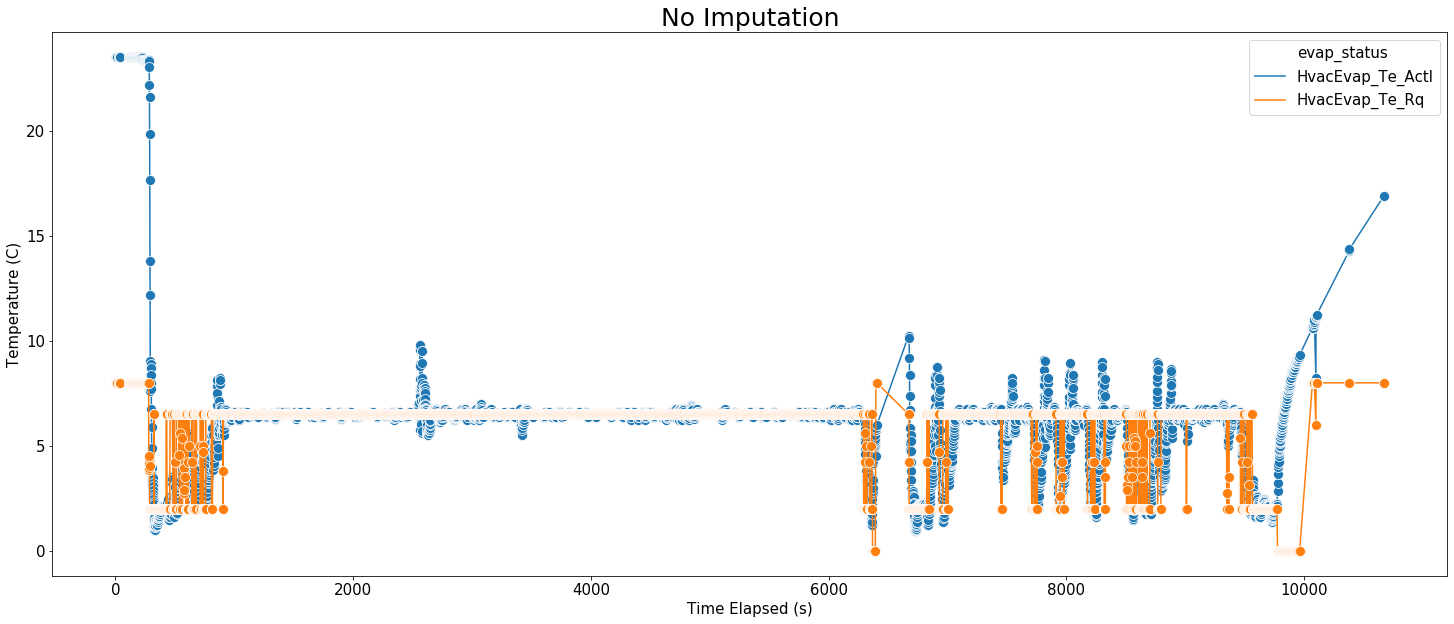

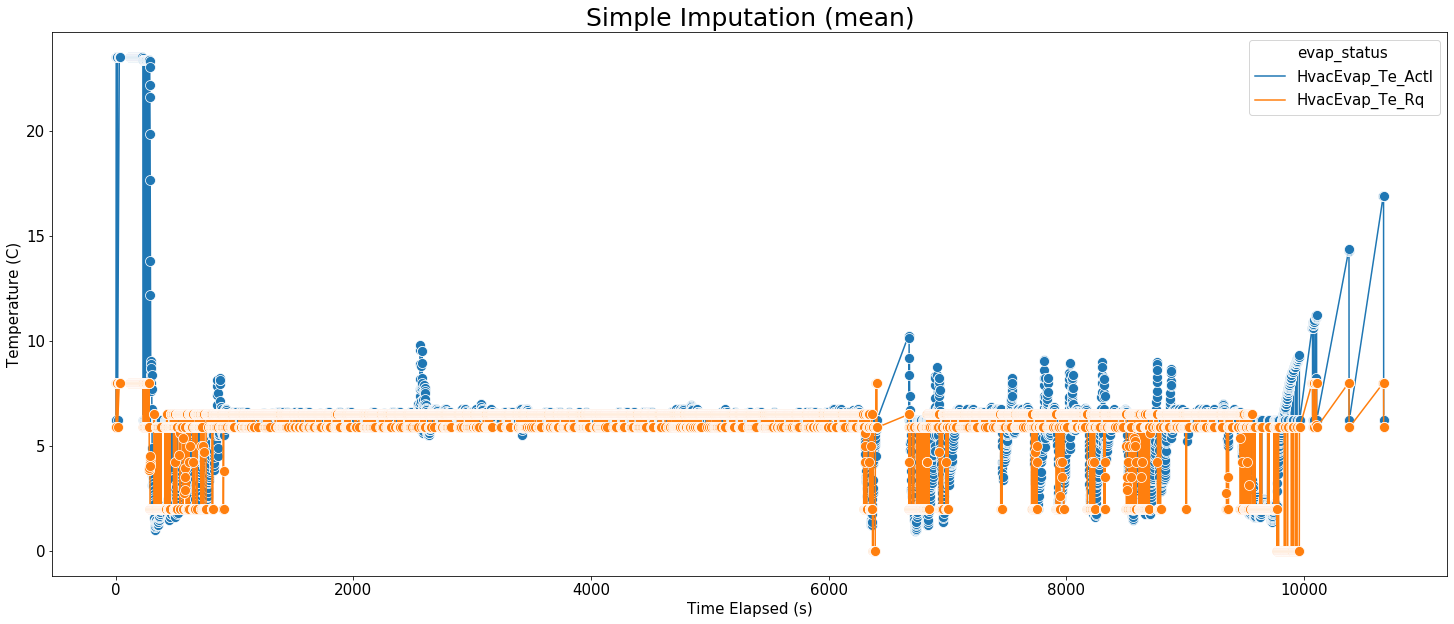

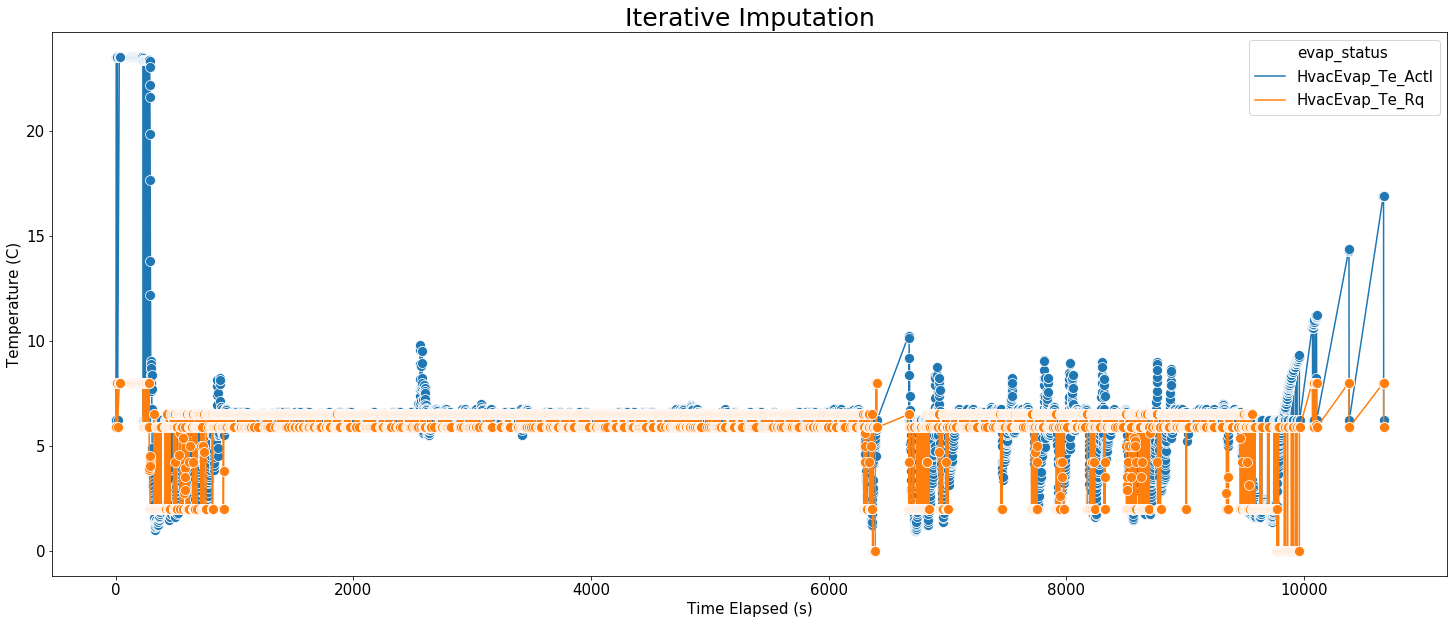

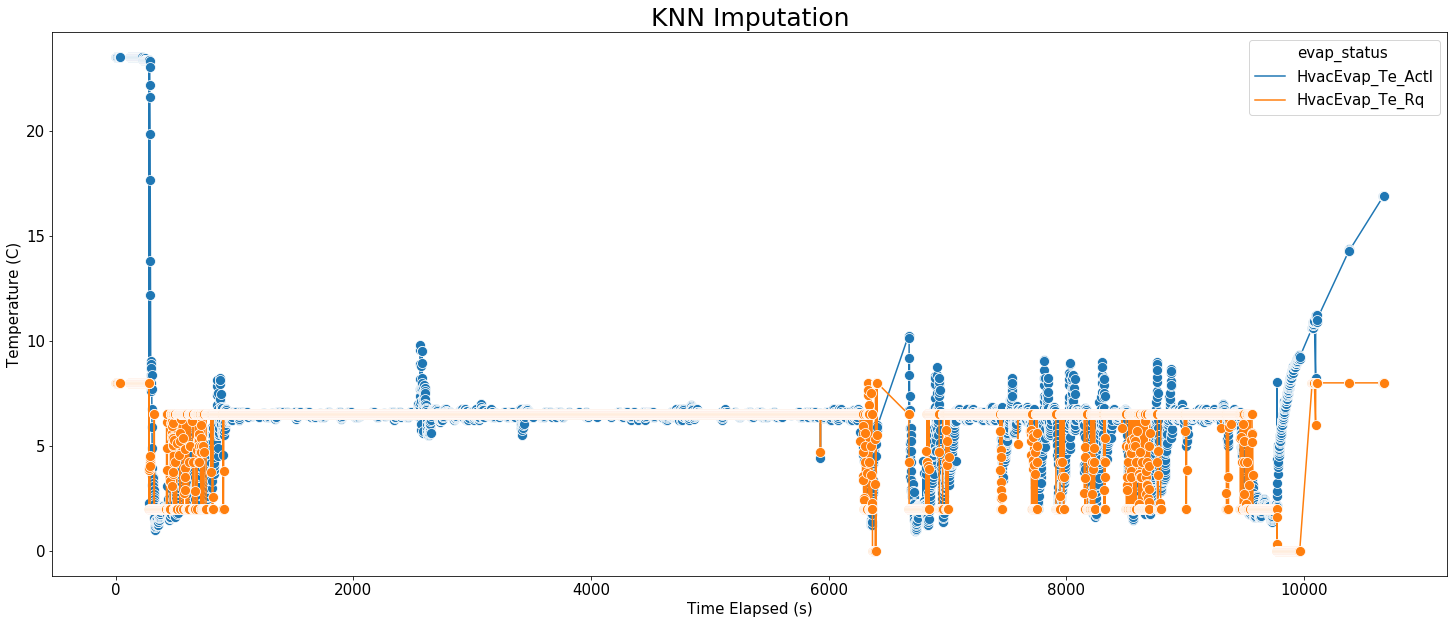

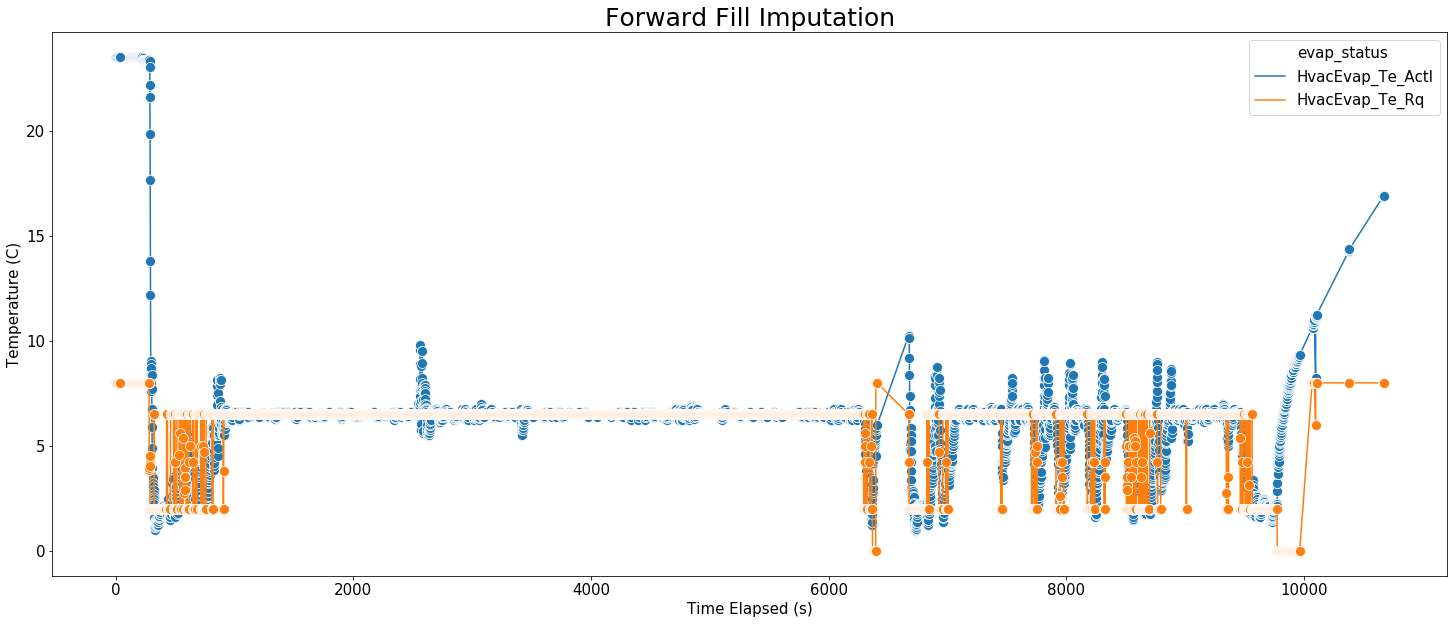

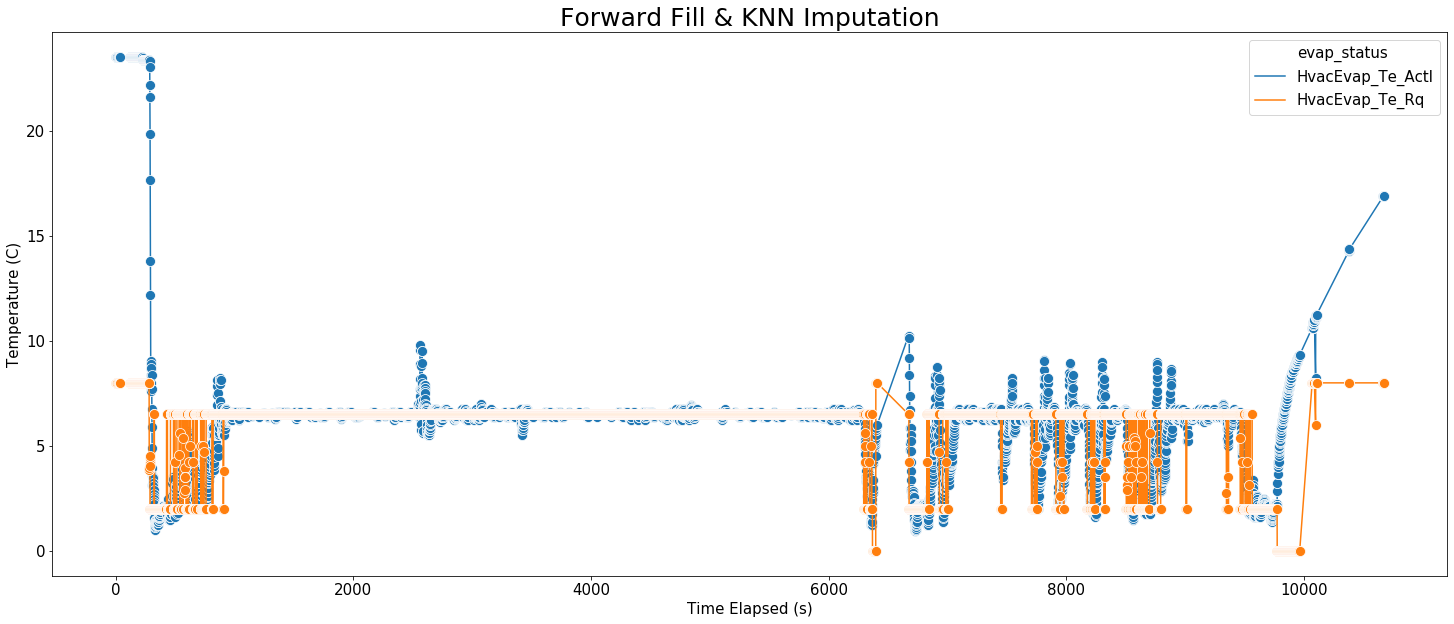

In [662]:
# trip 113 the longest

plot_gap(pivotted[pivotted['trip'] == 113], 'No Imputation', 'Time Elapsed (s)', 'Temperature (C)')
# fill nans using simple imputer
from sklearn.impute import SimpleImputer
trip113 = pivotted[pivotted['trip'] == 113]
trip113 = trip113[['epoch'] + list(trip113.columns[4:])]
imputer = SimpleImputer()
trip113_one_hot_encoded = pd.get_dummies(trip113)
trip113 = pd.DataFrame(imputer.fit_transform(trip113_one_hot_encoded), index=trip113.index, columns=trip113_one_hot_encoded.columns)
plot_gap(trip113, 'Simple Imputation (mean)', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
trip113 = pivotted[pivotted['trip'] == 113]
trip113 = trip113[['epoch'] + list(trip113.columns[4:])]
imputer = IterativeImputer()
trip113_one_hot_encoded = pd.get_dummies(trip113)
trip113 = pd.DataFrame(imputer.fit_transform(trip113_one_hot_encoded), index=trip113.index, columns=trip113_one_hot_encoded.columns)
plot_gap(trip113, 'Iterative Imputation', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using KNN imputer
from sklearn.impute import KNNImputer
trip113 = pivotted[pivotted['trip'] == 113]
trip113 = trip113[['epoch'] + list(trip113.columns[4:])]
imputer = KNNImputer(weights='distance')
trip113_one_hot_encoded = pd.get_dummies(trip113)
trip113 = pd.DataFrame(imputer.fit_transform(trip113_one_hot_encoded), index=trip113.index, columns=trip113_one_hot_encoded.columns)
plot_gap(trip113, 'KNN Imputation', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using forward fill
trip113 = pivotted[pivotted['trip'] == 113].fillna(method='ffill')
trip113 = trip113[['epoch'] + list(trip113.columns[4:])]
trip113_one_hot_encoded = pd.get_dummies(trip113)
trip113 = pd.DataFrame(imputer.fit_transform(trip113_one_hot_encoded), index=trip113.index, columns=trip113_one_hot_encoded.columns)
plot_gap(trip113, 'Forward Fill Imputation', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using combination of forward fill (features w/ >= 50% non-nulls) and KNN (remaining features)
cols_to_ffill = ['BrkTot_Tq_Actl', 'Veh_V_ActlEng', 'GearLvrPos_D_Actl','ApedPos_Pc_ActlArb', 'EngAout_N_Actl', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'HvacAirCond_B_Rq', 'BattULo_U_Actl', 'AirAmb_Te_ActlFilt', 'Outside_Air_Temp_Stat', 'OdometerMasterValue', 'VehLong2_A_Actl', 'temp_gap']
trip113 = pivotted[pivotted['trip'] == 113]
trip113 = trip113[['epoch'] + list(trip113.columns[4:])]
trip113[cols_to_ffill] = trip113[cols_to_ffill].fillna(method='ffill')
imputer = KNNImputer(weights='distance')
trip113_one_hot_encoded = pd.get_dummies(trip113)
trip113 = pd.DataFrame(imputer.fit_transform(trip113_one_hot_encoded), index=trip113.index, columns=trip113_one_hot_encoded.columns)
plot_gap(trip113, 'Forward Fill & KNN Imputation', 'Time Elapsed (s)', 'Temperature (C)')

There is added noise with all imputation techniques, but a combination of forward filling features with at least 50% non-null values and using KNN imputation for the remaining features seems the most optimal.

Let's fill our missing values using the above approach.

In [674]:
pivotted_f = [make_dummies_and_impute(trip) for trip in pivotted['trip'].unique()]
pivotted_f = pd.concat(pivotted_f)
pivotted_f = pd.concat([pivotted[pivotted.columns[:4]], pivotted_f], axis=1)
pivotted_f = pivotted_f.fillna(method='ffill').fillna(method='bfill') # remaining nans

Now, let's reverse the one-hot encoding.

In [675]:
categorical_vars = ['HvacBlwrFront_D_Stat', 'GearLvrPos_D_Actl', 'HvacAirCond_B_Rq', 'CoolantFanStepAct']
for var in categorical_vars:
    all_cols = pivotted_f.columns[17:]
    rel_cols = [col for col in all_cols if col.startswith(var) ]
    pivotted_f[var] = pivotted_f[rel_cols].idxmax(axis=1)

for var in categorical_vars:
    pivotted_f[var] = pivotted_f[var].map(lambda x: x[(x.index(var) + len(var) + 1):])

pivotted_f = pivotted_f[list(pivotted_f.columns[:17]) + list(pivotted_f.columns[-4:])]

Lastly, let's subset our data further by only looking at intervals where the AC is on.

In [679]:
pivotted_f = pivotted_f[pivotted_f['HvacAirCond_B_Rq'] == 'Yes'].reset_index(drop=True) # imputed data
pivotted = pivotted[pivotted['HvacAirCond_B_Rq'] == 'Yes'].reset_index(drop=True) # raw data

pivotted_f = pivotted_f.iloc[:,[i for i in range(len(pivotted_f.columns)) if i not in [2, 3, 4, 5, 6]]] # to get rid of duplicate epoch cols

pivotted_f['epoch_diff'] = pivotted_f['epoch'].diff() # recalc epoch diff since some trips now 
pivotted['epoch_diff'] = pivotted['epoch'].diff()


# recalc trips since we omitted intervals where AC off
flag_trips(pivotted_f)
pivotted_f = filter_trips(pivotted_f)
flag_trips(pivotted)
pivotted = filter_trips(pivotted)

In [694]:
# rearrange cols
pivotted_f = pivotted_f[list(pivotted_f.columns[0:2]) + list(pivotted_f.columns[-2:]) + list(pivotted_f.columns[2:-2])]

In [695]:
#pivotted_f.to_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_tripflags_imputed.csv', index=False)
#pivotted.to_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_tripflags_raw.csv', index=False)

Ultimately, we are left with 84 trips during the period from 05/01/19 to 07/26/19, and the distribution of trip durations and descriptive statistics are presented below.

In [686]:
from scipy.stats import describe

DescribeResult(nobs=84, minmax=(1.2166666666666666, 81.26666666666667), mean=21.796428571428567, variance=240.7503753107669, skewness=1.6431455883863186, kurtosis=3.015235810093852)


Text(0, 0.5, 'Density')

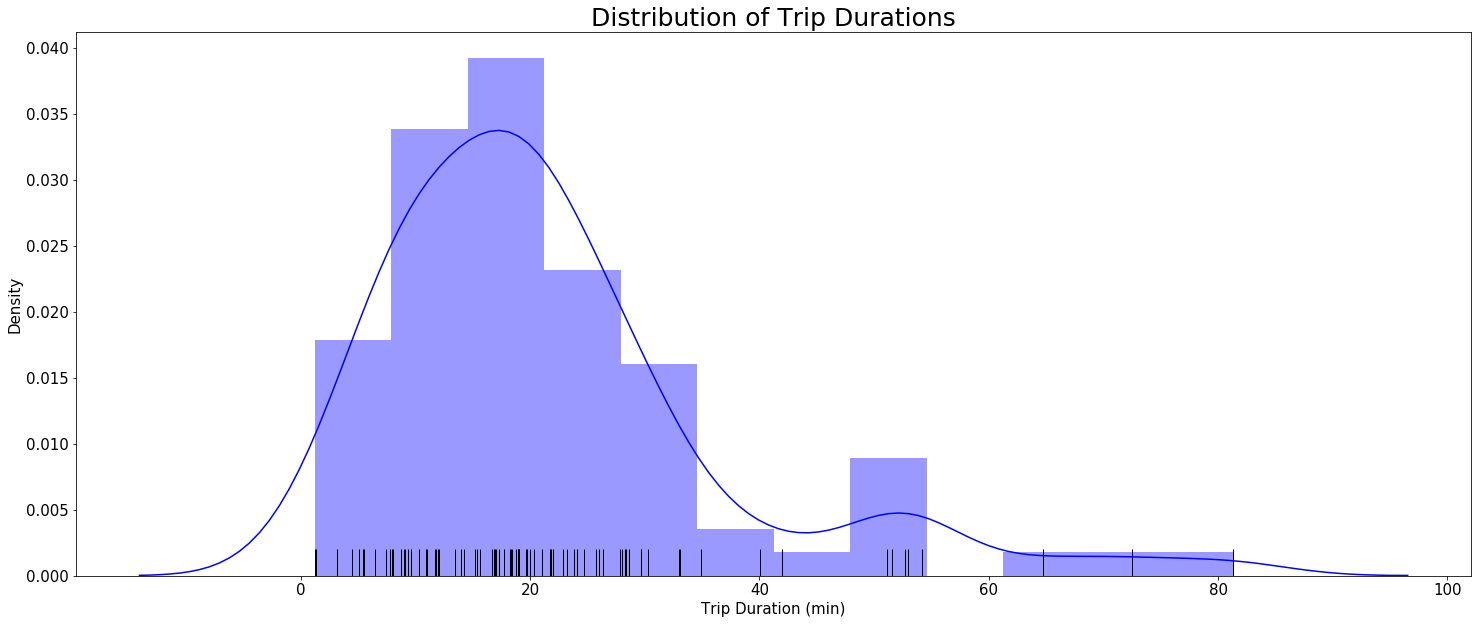

In [687]:
print(describe(pivotted_f.groupby('trip')['epoch'].agg(lambda x: x.max() - x.min())/60))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(pivotted_f.groupby('trip')['epoch'].agg(lambda x: x.max() - x.min())/60, color='Blue', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Trip Durations', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Trip Duration (min)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)



DescribeResult(nobs=83, minmax=(30.516666666666666, 24219.083333333332), mean=1323.6590361445783, variance=15593934.733735101, skewness=4.82982060817113, kurtosis=22.391078759435153)


Text(0, 0.5, 'Density')

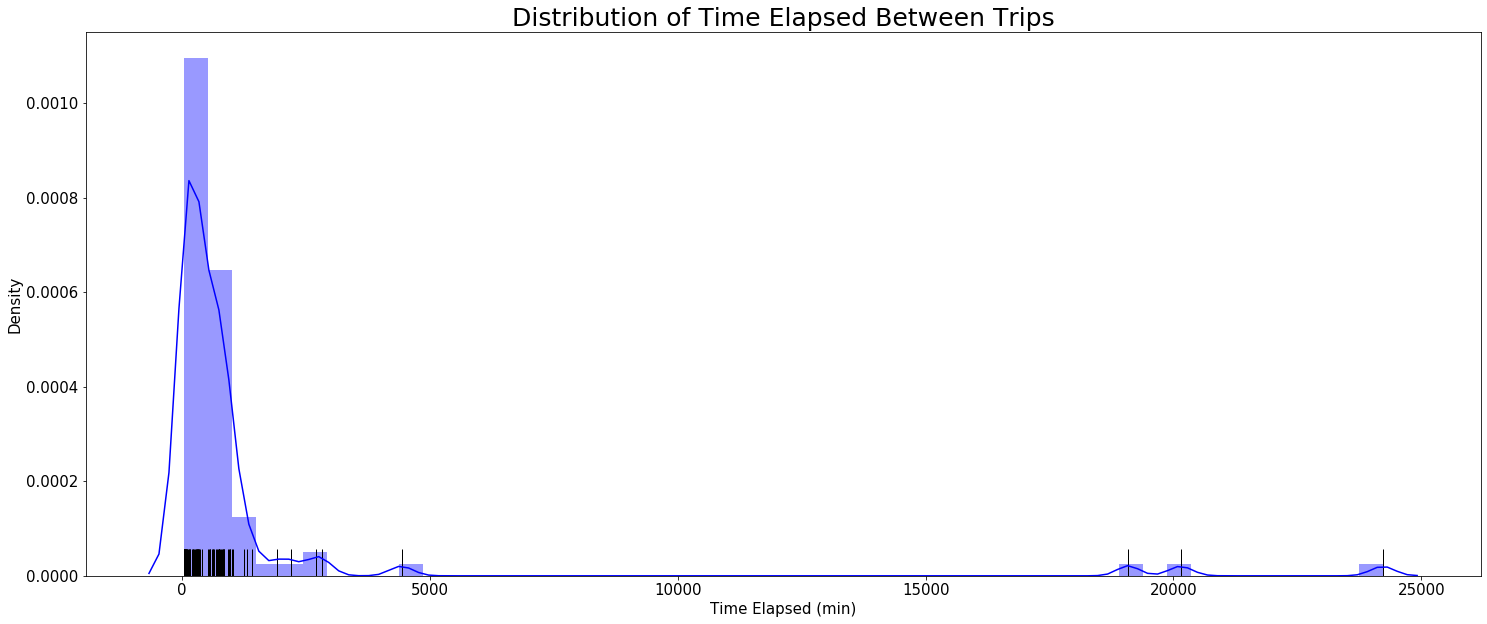

In [688]:
print(describe(pivotted_f['epoch_diff'][pivotted_f['epoch_diff'] > 1800]/60))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(pivotted_f['epoch_diff'][pivotted_f['epoch_diff'] > 1800]/60, color='Blue', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Time Elapsed Between Trips', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Time Elapsed (min)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)
